In [8]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install torchbearer

     |████████████████████████████████| 143kB 4.9MB/s 


In [26]:
import torch
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
from torch import nn
from torch.nn import functional as F
from torch import optim
import torchbearer
from torch.utils.data import DataLoader, Dataset
from datetime import datetime
import matplotlib.pyplot as plt

In [11]:
df = pd.read_csv('/content/drive/My Drive/MSc/data/data.csv')

In [13]:
df = df.drop(['Attributes'], axis=1)
df = df.drop([1], axis=0)
col = [att + ' ' + df[att][0] for att in df.columns]
df.columns = col
df = df.drop([0])

In [14]:
df.columns

Index(['Adj Close AAPL', 'Adj Close.1 GOOGL', 'Adj Close.2 MSFT',
       'Adj Close.3 ^IXIC', 'Adj Close.4 ^GSPC', 'Close AAPL', 'Close.1 GOOGL',
       'Close.2 MSFT', 'Close.3 ^IXIC', 'Close.4 ^GSPC', 'High AAPL',
       'High.1 GOOGL', 'High.2 MSFT', 'High.3 ^IXIC', 'High.4 ^GSPC',
       'Low AAPL', 'Low.1 GOOGL', 'Low.2 MSFT', 'Low.3 ^IXIC', 'Low.4 ^GSPC',
       'Open AAPL', 'Open.1 GOOGL', 'Open.2 MSFT', 'Open.3 ^IXIC',
       'Open.4 ^GSPC', 'Volume AAPL', 'Volume.1 GOOGL', 'Volume.2 MSFT',
       'Volume.3 ^IXIC', 'Volume.4 ^GSPC'],
      dtype='object')

In [15]:
close_aapl = df['Close AAPL'].copy().to_numpy()

In [16]:
close_aapl_scaler = preprocessing.MinMaxScaler()
close_aapl = close_aapl_scaler.fit_transform(close_aapl.reshape(-1, 1))

In [31]:
dates = pd.read_csv('/content/drive/My Drive/MSc/data/data.csv')['Attributes'].drop([0,1]).to_numpy()
dates = [datetime.strptime(date, '%Y-%m-%d') for date in dates]

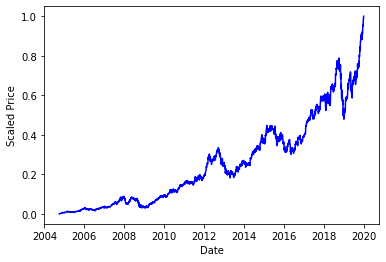

In [33]:
import matplotlib.pyplot as plt
plt.xlabel('Date')
plt.ylabel('Scaled Price')
plt.plot(dates, close_aapl,color='blue')

In [34]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

class lstm(nn.Module) :
    def __init__(self, input_size, hidden_size, hidden1, n_layers, seq_len) :
        super(lstm, self).__init__()
        self.insize = input_size
        self.hdsize = hidden_size
        self.ousize = 1
        self.seq_len = seq_len
        self.layer = n_layers
        self.lstm_cell = nn.LSTM(input_size=self.insize,
            hidden_size=self.hdsize,num_layers=self.layer, batch_first=True)
        self.fc = nn.Linear(self.hdsize, hidden1)
        self.fc1 = nn.Linear(hidden1, 1)

    def forward(self, x) :
        self.h_state = (torch.zeros(self.layer, len(x), self.hdsize).to(device),
                        torch.zeros(self.layer, len(x), self.hdsize).to(device))
        lstm_out, self.h_state = self.lstm_cell(x, self.h_state)
        out = lstm_out.squeeze()[:,-1,:]
        out = self.fc(out)
        out = F.sigmoid(out)
        out = self.fc1(out)
        return out

In [35]:
aapl = torch.from_numpy(close_aapl)

In [36]:
def create_dataset(data_scaled, seq_length, distance) :
    xs = []
    ys = []
    for i in range(data_scaled.shape[0]-distance-seq_length-1) :
        x = data_scaled.clone()[i:i+seq_length]
        y = data_scaled.clone()[i+seq_length+distance-1]
        xs.append(x)
        ys.append(y)
    return xs, ys

In [37]:
seq_length = 50
distance = 7
xs, ys = create_dataset(aapl, seq_length, distance)
xs = torch.stack(xs)
ys = torch.stack(ys)
xs.shape, ys.shape

(torch.Size([3781, 50, 1]), torch.Size([3781, 1]))

In [38]:
train_inp = xs.clone()[:3500,:]
train_out = ys.clone()[:3500]
test_inp = xs.clone()[3500:,:]
test_out = ys.clone()[3500:]

In [39]:
train_inp = train_inp.to(device).float()
train_out = train_out.to(device).float()
test_inp = test_inp.to(device).float()
test_out = test_out.to(device).float()

In [48]:
model = lstm(1, 50, 128, 1, seq_length).to(device)
optimiser = optim.Adam(model.parameters(), lr=1e-3)
epoch = 100

loss_function = nn.MSELoss(reduction='sum')

train_hist = torch.zeros(epoch)
test_hist = torch.zeros(epoch)

for e in range(epoch) :
    
    train_pred = model(train_inp)

    train_loss = loss_function(train_pred.float(), train_out)

    with torch.no_grad() :
        test_pred = model(test_inp) 
        test_loss = loss_function(test_pred.float(), test_out)
    
    train_hist[e] = train_loss.item()
    test_hist[e] = test_loss.item()

    if e % 10 == 0 :
        print('Train loss:', train_hist[e], '\nTest loss:', test_hist[e])

    optimiser.zero_grad()

    train_loss.backward()

    optimiser.step()


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train loss: tensor(221.7669) 
Test loss: tensor(116.4692)
Train loss: tensor(120.8513) 
Test loss: tensor(61.2247)
Train loss: tensor(116.1674) 
Test loss: tensor(56.4042)
Train loss: tensor(103.7982) 
Test loss: tensor(57.5581)
Train loss: tensor(32.8224) 
Test loss: tensor(4.8593)
Train loss: tensor(10.5197) 
Test loss: tensor(4.0865)
Train loss: tensor(7.7094) 
Test loss: tensor(7.8773)
Train loss: tensor(3.9953) 
Test loss: tensor(2.4853)
Train loss: tensor(2.6346) 
Test loss: tensor(2.6799)
Train loss: tensor(1.9870) 
Test loss: tensor(1.8099)


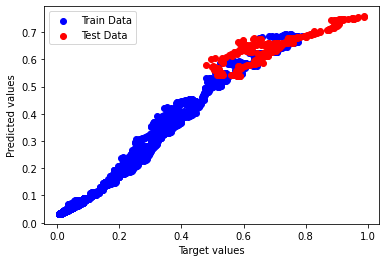

In [49]:
import matplotlib.pyplot as plt

plt.scatter(train_out.cpu().detach(), train_pred.cpu().detach(),color='blue')
plt.scatter(test_out.cpu().detach(), test_pred.cpu().detach(),color='red')
plt.ylabel('Predicted values')
plt.xlabel('Target values')
plt.legend(['Train Data', 'Test Data'])

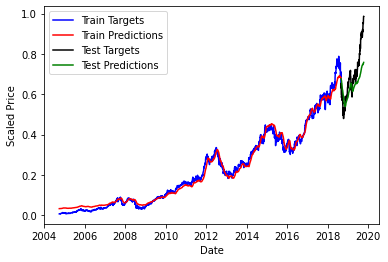

In [50]:
plt.plot(dates[:len(train_out)], train_out.cpu().detach(), color='blue')
plt.plot(dates[:len(train_pred)], train_pred.cpu().detach(), color='red')
plt.plot(dates[len(train_out): len(train_out) + len(test_out)], test_out.cpu().detach(), color='black')
plt.plot(dates[len(train_pred): len(train_pred) + len(test_pred)], test_pred.cpu().detach(), color='green')
plt.xlabel('Date')
plt.ylabel('Scaled Price')
plt.legend(['Train Targets', 'Train Predictions', 'Test Targets', 'Test Predictions'])

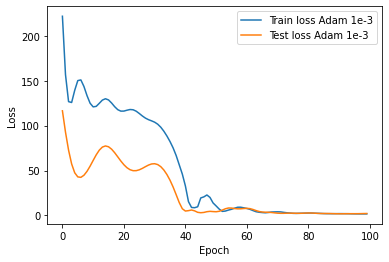

In [52]:
plt.plot(range(epoch),train_hist)
plt.plot(range(epoch),test_hist)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss Adam 1e-3', 'Test loss Adam 1e-3'])